# STEP # 2 - TRAIN NAIVE BAYES CLASSIFIER. 
## Our goal is to predict patient diagnoses, procedures, services and Rx. In the previous notebook, we only read claims data and prepared the data suitable for training. In this notebook, we train models and perform predictions.

In [1]:
import os
import pandas as pd
import numpy as np
from ConstantsNamespace import PatientJourneyConstantsNamespace

### Constants for file names

In [2]:
constants = PatientJourneyConstantsNamespace()

### Read the saved output of Step # 1 , i.e. 
### (1) input data on 160 features, output data on 160 features, repeat features and new features. All these are one-hot-encoded.
### (2) Read dataframe 'unique_featureids_and_desc'which has metadata of features¶

In [3]:
featureid_id_bubbled_down_x = np.load('step_01_output/featureid_id_bubbled_down_x.npy')
featureid_id_bubbled_down_y = np.load('step_01_output/featureid_id_bubbled_down_y.npy')
repeat_features = np.load('step_01_output/repeat_features.npy')
new_features = np.load('step_01_output/new_features.npy')

unique_featureids_and_desc = pd.read_csv('step_01_output/unique_featureids_and_desc', sep='\t', header=0)

### Verify the feature id for BETA BLOCKERS

In [4]:
unique_featureids_and_desc[unique_featureids_and_desc['Level1']=='BETA BLOCKERS']

,featureid_id,featuretype,Level1
63,63,rx,BETA BLOCKERS


#### Create 'train_data' and 'test_data'. 
#### Create 'train label' and 'test_label' specifically for BETA BLOCKERS 

In [5]:
test_data   = featureid_id_bubbled_down_x[0:1000]
test_labels = new_features[0:1000][:,63] # 63 is for BETA BLOCKERS

train_data   = featureid_id_bubbled_down_x[1000:]
train_labels = new_features[1000:][:,63] # 63 is for BETA BLOCKERS

## Our dataset features and labels are all categorical and all are one-hot-encoded. So, we don't need to make feature transformations such as standard scaling, one-hot-encoding etc.  

In [6]:
# Let's try the ComplementNB and CategoricalNB flavors of the Naive Bayes
from sklearn.naive_bayes import ComplementNB, CategoricalNB
from sklearn.metrics import confusion_matrix

complementNB_clf = ComplementNB(force_alpha=True)
complementNB_clf.fit(train_data, train_labels)

categoricalNB_clf = CategoricalNB(force_alpha=True)
categoricalNB_clf.fit(train_data, train_labels)

CategoricalNB(force_alpha=True)

In [7]:
def get_normalized_train_and_test_confusion_matrices(clf):
    # Predict on both train and test data
    train_preds = clf.predict(train_data)
    test_preds = clf.predict(test_data)

    # Confusion matrix for predictions on train data 
    train_conf_mat = confusion_matrix(train_labels, train_preds)
    # Normalize values by dividing by the rowsums
    train_row_sums = train_conf_mat.sum(axis=1, keepdims=True)
    train_norm_conf_mat = train_conf_mat/train_row_sums
    
    # Confusion matrix for predictions on test data 
    test_conf_mat = confusion_matrix(test_labels, test_preds)
    # Normalize values by dividing by the rowsums
    test_row_sums = test_conf_mat.sum(axis=1, keepdims=True)
    test_norm_conf_mat = test_conf_mat/test_row_sums

    print('Confusion Matrices for Classifier:', clf.__class__.__name__)
    print('\nNormalized Confusion Matrix on Train Data\n', train_norm_conf_mat)
    print('\nNormalized Confusion Matrix on Test Data\n', test_norm_conf_mat)
    
    return train_norm_conf_mat, test_norm_conf_mat

In [8]:
import matplotlib.pyplot as plt

def plot_normalized_train_and_test_confusion_matrices(train_norm_conf_mat, test_norm_conf_mat):
    np.fill_diagonal(train_norm_conf_mat, 0)
    np.fill_diagonal(test_norm_conf_mat, 0)

    fig, axs = plt.subplots(1, 2, figsize=(6,3))
    fig.subplots_adjust(top=0.7)
    axs[0].matshow(train_norm_conf_mat, cmap=plt.cm.gray)
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')
    axs[0].set_title('Train Data')

    
    axs[1].matshow(test_norm_conf_mat, cmap=plt.cm.gray)
    axs[1].set_xlabel('Predicted')
    axs[1].set_ylabel('Actual')
    axs[1].set_title('Test Data')

    fig.suptitle('. '.join(['Normalized Confusion Matrices', 'Diagonals zeroed as we are interested in errors', 'Bright Areas imply misclassification']))

## Get confusion matrix for ComplementNB

In [9]:
train_norm_conf_mat, test_norm_conf_mat = get_normalized_train_and_test_confusion_matrices(complementNB_clf)

Confusion Matrices for Classifier: ComplementNB

Normalized Confusion Matrix on Train Data
 [[0.70972578 0.29027422]
 [0.27390972 0.72609028]]

Normalized Confusion Matrix on Test Data
 [[0.63673058 0.36326942]
 [0.11111111 0.88888889]]


### From above confusion matrix, we see that on train data, the model correctly predicts label=1, ~72.6% of the times whereas on the test data, it is correct ~88.9% of the times - This is a very good number considering how simple Naive Bayes implementation is.

### Let's closely analyze the error predictions though. For this, let's zero out the diagonals (i.e. the correct predictions) and only look at the errors (non-diagnonals). In the plot below, 0 will be in complete black color and 1 will be completely white. Columns are the predicted values and rows are actual values. Observe, that on test data, there is a fair amount of misclassification where label=0 is wrongly predicted as label=1 (white color). This might actually be OK - because when one wants to predict who will use BETA BLOCKERS, one might not care about the False Positives. One would actually want to look into these cases and make a judgment considering other factors.  

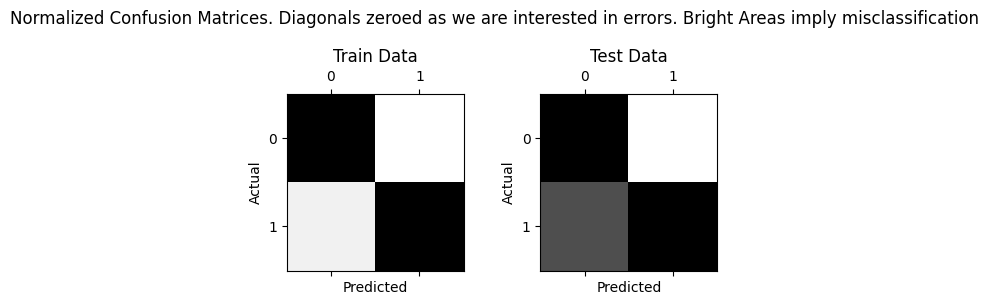

In [10]:
plot_normalized_train_and_test_confusion_matrices(train_norm_conf_mat, test_norm_conf_mat)

## Get confusion matrix for CategoricalNB

In [11]:
train_norm_conf_mat, test_norm_conf_mat = get_normalized_train_and_test_confusion_matrices(categoricalNB_clf)

Confusion Matrices for Classifier: CategoricalNB

Normalized Confusion Matrix on Train Data
 [[0.89290617 0.10709383]
 [0.61897475 0.38102525]]

Normalized Confusion Matrix on Test Data
 [[0.9172553  0.0827447 ]
 [0.55555556 0.44444444]]


### From above confusion matrix, we see that on train data, the model correctly predicts label=1, ~38.1% of the times whereas on the test data, it is correct ~44.44% of the times. This is way worse than numbers we saw above for ComplementNB.

### Let's do a similar plot by zeroing the diagonals and seeing the errors. We can see that on test data, there is high misclassification where label=1 is wrongly predicted as label=0 (False Negative). In general, this is not good as we're missing more patients. 

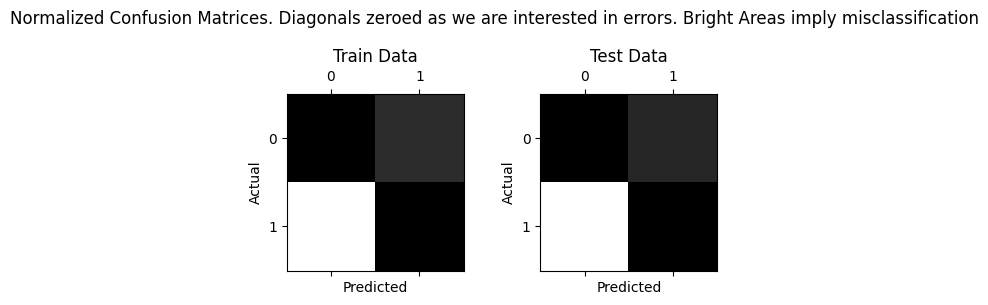

In [12]:
plot_normalized_train_and_test_confusion_matrices(train_norm_conf_mat, test_norm_conf_mat)